###### Multi-region analysis 

In this notebook we analyse the ability of a model trained on a region A to infer the subgrid forcing to achieve the same task on a different region, say region B. 

In [1]:
import mlflow
import xarray as xr
import matplotlib.pyplot as plt
from analysis.utils import select_run

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable, Mapping
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Siz

In [2]:
plt.rcParams["figure.figsize"] = (15, 10)

In [3]:
def plot_dataset(dataset : xr.Dataset, plot_type = None, *args, **kargs):
    """Calls the plot function of each variable in the dataset"""
    plt.figure(figsize = (20, 5 * int(len(dataset) / 2)))
    kargs_ = [dict() for i in range(len(dataset))]
    def process_list_of_args(name: str):
        if name in kargs:
            if isinstance(kargs[name], list):
                for i, arg_value in enumerate(kargs[name]):
                    kargs_[i][name] = arg_value
            else:
                for i in range(len(dataset)):
                    kargs_[i][name] = kargs[name]
            kargs.pop(name)
    process_list_of_args('vmin')
    process_list_of_args('vmax')
    for i, variable in enumerate(dataset):
        plt.subplot(int(len(dataset) / 2), 2, i + 1)
        if plot_type is None:
            try:
                # By default we set the cmap to coolwarm
                kargs.setdefault('cmap', 'coolwarm')
                dataset[variable].plot(*args, **kargs_[i], **kargs)
            except AttributeError as e:
                kargs.pop('cmap', None)
                dataset[variable].plot(*args, **kargs)
        else:
            plt_func = getattr(dataset[variable].plot, plot_type)
            plt_func(*args, **kargs)
import matplotlib.animation as animation

def dataset_to_movie(dataset : xr.Dataset, interval : int = 50,
                    *args, **kargs):
    """Generates animations for all the variables in the dataset"""
    fig = plt.figure(figsize = (20, 5 * int(len(dataset) / 2)))
    axes = list()
    ims = list()
    for i, variable in enumerate(dataset.keys()):
        axes.append(fig.add_subplot(int(len(dataset) / 2), 2, i + 1))
    for i, t in enumerate(dataset['time']):
        im = list()
        for axis, variable in zip(axes, dataset.keys()):
            plt.sca(axis)
            img = dataset[variable].isel(time=i).plot(vmin=-2, vmax=2,
                                                      cmap='coolwarm')
            cb = img.colorbar
            cb.remove()
            im.append(img)
        ims.append(im)
    ani = animation.ArtistAnimation(fig, ims, 
                                    interval=interval, blit=True,
                                    repeat_delay=1000)
    return ani

In [4]:
client = mlflow.tracking.MlflowClient()
client.list_experiments()

[<Experiment: artifact_location='/scratch/ag7531/mlruns/6', experiment_id='6', lifecycle_stage='active', name='multiregion', tags={}>,
 <Experiment: artifact_location='/scratch/ag7531/mlruns/11', experiment_id='11', lifecycle_stage='active', name='meeting25June', tags={}>,
 <Experiment: artifact_location='/scratch/ag7531/mlruns/3', experiment_id='3', lifecycle_stage='active', name='multiregions', tags={}>,
 <Experiment: artifact_location='/scratch/ag7531/mlruns/10', experiment_id='10', lifecycle_stage='active', name='multimodal', tags={}>,
 <Experiment: artifact_location='/scratch/ag7531/mlruns/1', experiment_id='1', lifecycle_stage='active', name='forcingdata', tags={}>,
 <Experiment: artifact_location='/scratch/ag7531/mlruns/2', experiment_id='2', lifecycle_stage='active', name='training', tags={}>,
 <Experiment: artifact_location='/scratch/ag7531/mlruns/4', experiment_id='4', lifecycle_stage='active', name='default', tags={}>,
 <Experiment: artifact_location='/scratch/ag7531/mlruns/

In [5]:
import pandas as pd
def select_run(limit=1000, sort_by=None, cols=None, merge=None, *args, **kargs):
    """Allows to select a run from the tracking store interactively"""
    mlflow_runs = mlflow.search_runs(*args, **kargs)
    if cols is None:
        cols = list()
    cols = ['run_id', 'experiment_id' ] + cols
    mlflow_runs = mlflow_runs.iloc[:limit]
    # Remove possible duplicate columns
    new_cols = list()
    for e in cols:
        if e not in new_cols:
            new_cols.append(e)
    cols = new_cols
    print(len(mlflow_runs))
    if merge is not None:
        cols[cols.index('run_id')] = 'run_id_x'
        cols[cols.index('experiment_id')] = 'experiment_id_x'
        for name, key_left, key_right in merge:
            experiment = mlflow.get_experiment_by_name(name)
            df2 = mlflow.search_runs(experiment_ids=experiment.experiment_id)
            mlflow_runs = pd.merge(mlflow_runs, df2, left_on=key_left,
                                   right_on=key_right)
    print(len(mlflow_runs))
    if len(mlflow_runs) == 0:
        raise Exception('No data found. Check that you correctly set \
                        the store')
    if sort_by is not None:
        mlflow_runs = mlflow_runs.sort_values(by=sort_by, ascending=False)
        cols.append(sort_by)
    print(mlflow_runs[cols])
    id_ = int(input('Run id?'))
    if id_ < 0:
        sys.exit()
    return mlflow_runs.loc[id_, :]

In [6]:
cols = ['start_time_x','params.model_cls_name', 'metrics.test loss', 'params.lat_min', 
       'params.lat_max', 'params.long_min', 'params.long_max', 'params.n_epochs_x', 'params.model_run_id']
run = select_run(sort_by='start_time_x', cols=cols, merge=[('Unet', 'params.model_run_id', 'run_id'),
                                  ('forcingdata1pct', 'params.data_run_id', 'run_id')], experiment_ids = ['11',])

7
2
                           run_id_x experiment_id_x  \
0  08c1c58ef8dd4669999bf355b8459aea              11   
1  c55c0b2985244decbc7e20cc1a5d35c0              11   

                      start_time_x params.model_cls_name  metrics.test loss  \
0 2020-06-25 12:31:17.256000+00:00                Unet32          -1.515098   
1 2020-06-25 11:16:35.717000+00:00                Unet32          -1.347764   

  params.lat_min params.lat_max params.long_min params.long_max  \
0             35             50             -50             -20   
1             35             50             -50             -20   

  params.n_epochs_x               params.model_run_id  \
0                 0  8351e0c188d14be5a28abdce1cf01f5d   
1                 0  e663efdb6c40493d8e06b80647f7acdf   

                      start_time_x  
0 2020-06-25 12:31:17.256000+00:00  
1 2020-06-25 11:16:35.717000+00:00  
Run id?0


In [7]:
for k,v in run.items():
    print(f'{k}: {v}')

run_id_x: 08c1c58ef8dd4669999bf355b8459aea
experiment_id_x: 11
status_x: FINISHED
artifact_uri_x: /scratch/ag7531/mlruns/11/08c1c58ef8dd4669999bf355b8459aea/artifacts
start_time_x: 2020-06-25 12:31:17.256000+00:00
end_time_x: 2020-06-25 12:33:03.144000+00:00
metrics.validation loss: 0.0
metrics.Inf Norm_x: 1.7839448673839797e-06
metrics.mse_x: 0.06976134034679163
params.model_run_id: 8351e0c188d14be5a28abdce1cf01f5d
params.data_run_id: a47e3597568146b088f1f17b17111e29
params.n_epochs_x: 0
tags.mlflow.source.type_x: LOCAL
tags.mlflow.source.name_x: /home/ag7531/code/subgrid/testing/main.py
tags.mlflow.source.git.commit_x: 7aafd1426a54f64359f715b4aede609401ea9ab1
tags.mlflow.user_x: ag7531
run_id_y: 8351e0c188d14be5a28abdce1cf01f5d
experiment_id_y: 7
status_y: FINISHED
artifact_uri_y: /scratch/ag7531/mlruns/7/8351e0c188d14be5a28abdce1cf01f5d/artifacts
start_time_y: 2020-06-24 08:36:30.211000+00:00
end_time_y: 2020-06-24 10:16:51.655000+00:00
metrics.train loss: -1.6850772797158255
metric

In [8]:
data_run_id = run['params.data_run_id']
data_run = client.get_run(data_run_id)

In [9]:
from analysis.base import get_test_datasets
test_datasets = get_test_datasets(run['run_id_x'])

. test_output_0 .
loading


In [10]:
id = 0
error = (test_datasets[id]['S_xpred'] - test_datasets[id]['S_x']) 
error0 = test_datasets[id]['S_x']

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Iterator):


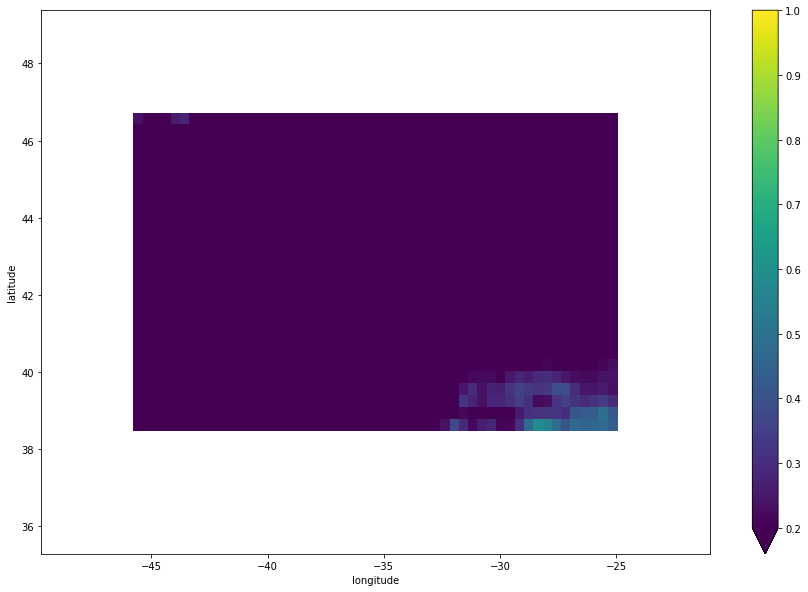

In [11]:
((error**2).mean(dim='time') / (error0**2).mean(dim='time')).plot(vmin=0.2, vmax=1)

In [12]:
import numpy as np
model_output = test_datasets[id]
model_output['S_xscale'] = 1/(model_output['S_xscale'])
model_output['S_yscale'] = 1/(model_output['S_yscale'])
model_output['err_S_x'] = (model_output['S_x'] - model_output['S_xpred'])**2
model_output['err_S_y'] = (model_output['S_y'] - model_output['S_ypred'])**2

In [13]:
model_output['time_index'] = xr.DataArray(np.arange(len(model_output.coords['time'])),
                                       dims = ('time',),
                                       coords = {'time' : model_output['time']})
model_output = model_output.swap_dims({'time' : 'time_index'})

2154


/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


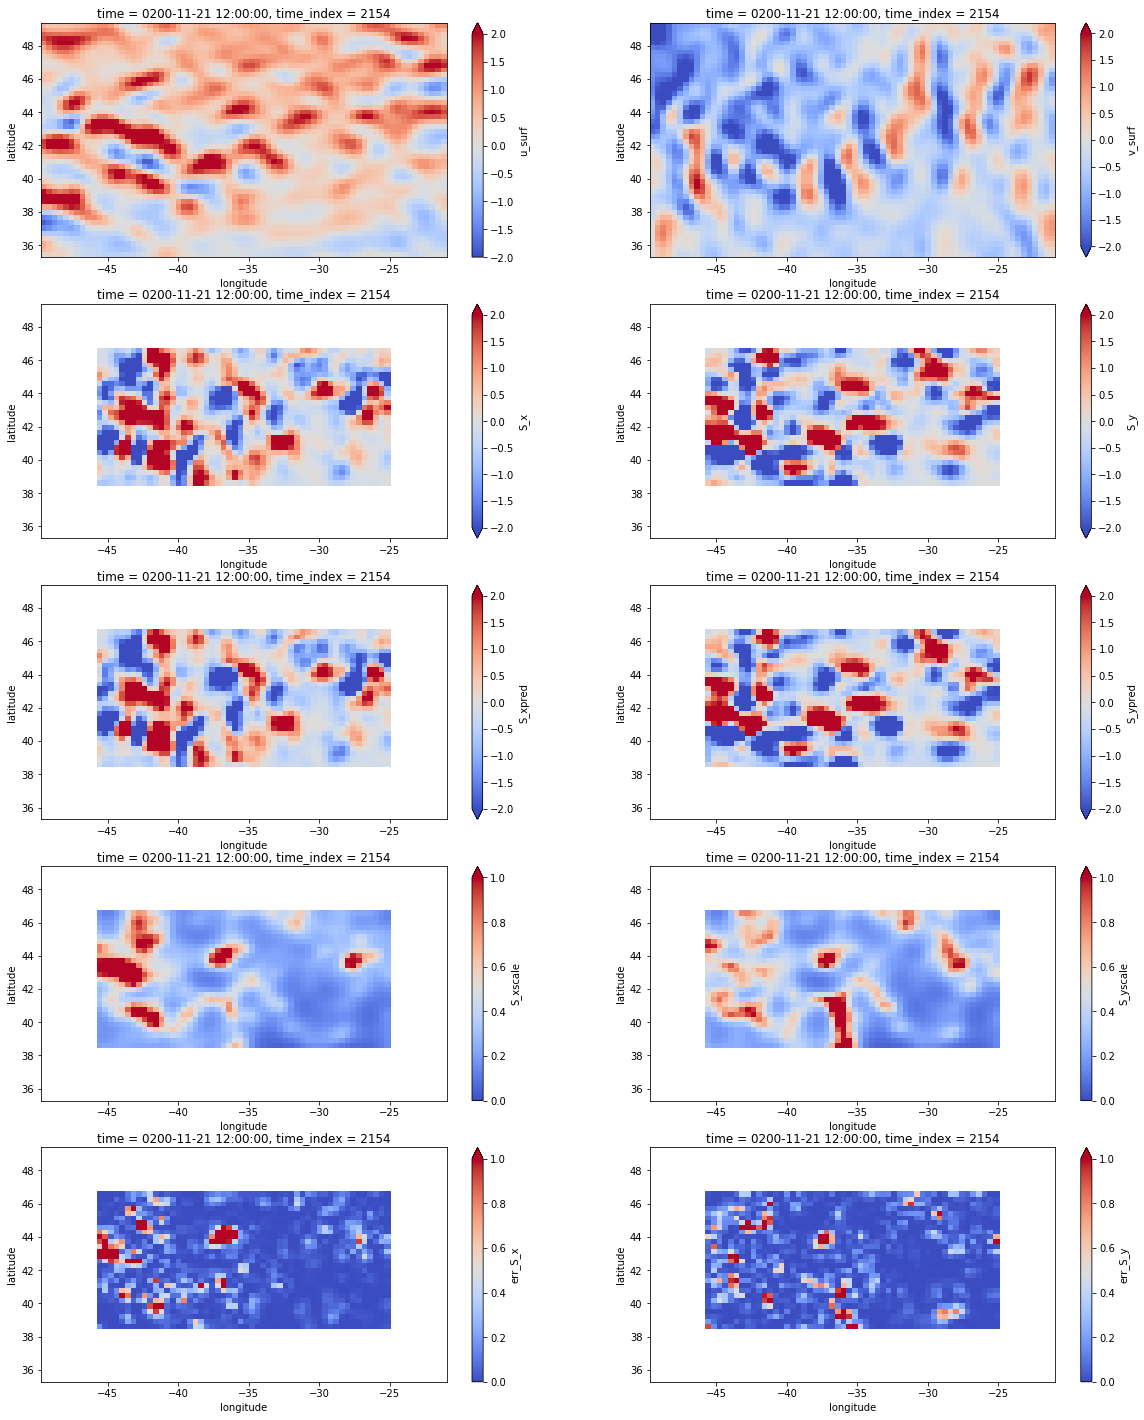

In [14]:
from random import randint
n_times = len(model_output['time'])
random_time = randint(0, n_times)
print(random_time)
plot_dataset(model_output.isel(time_index=random_time)[['u_surf', 'v_surf', 'S_x', 'S_y', 'S_xpred', 'S_ypred',
                                                          'S_xscale', 'S_yscale', 'err_S_x', 'err_S_y']],
            vmin = [-2]*6 + [0., 0., 0., 0.], vmax = [2]*6 + [1, 1,1,1])

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


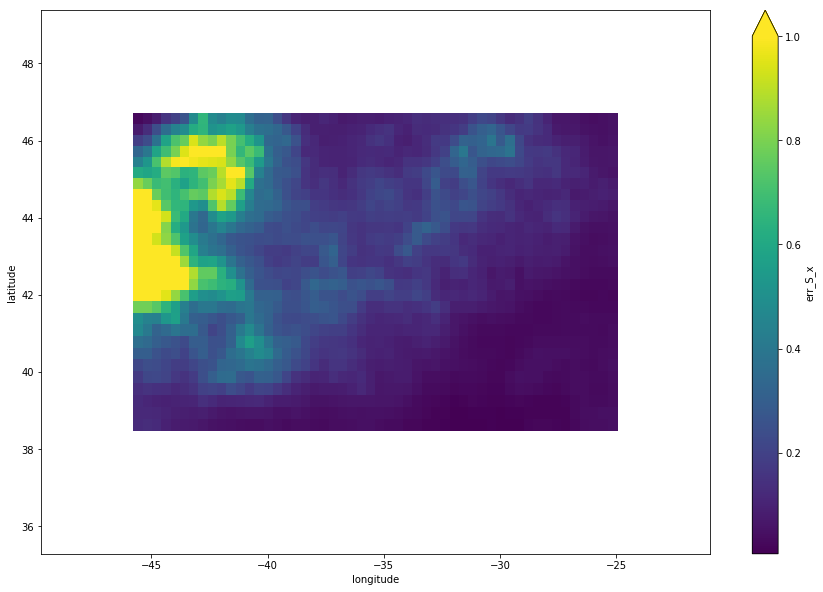

In [15]:
(model_output['err_S_x']).mean(dim='time_index').plot(vmax=1)

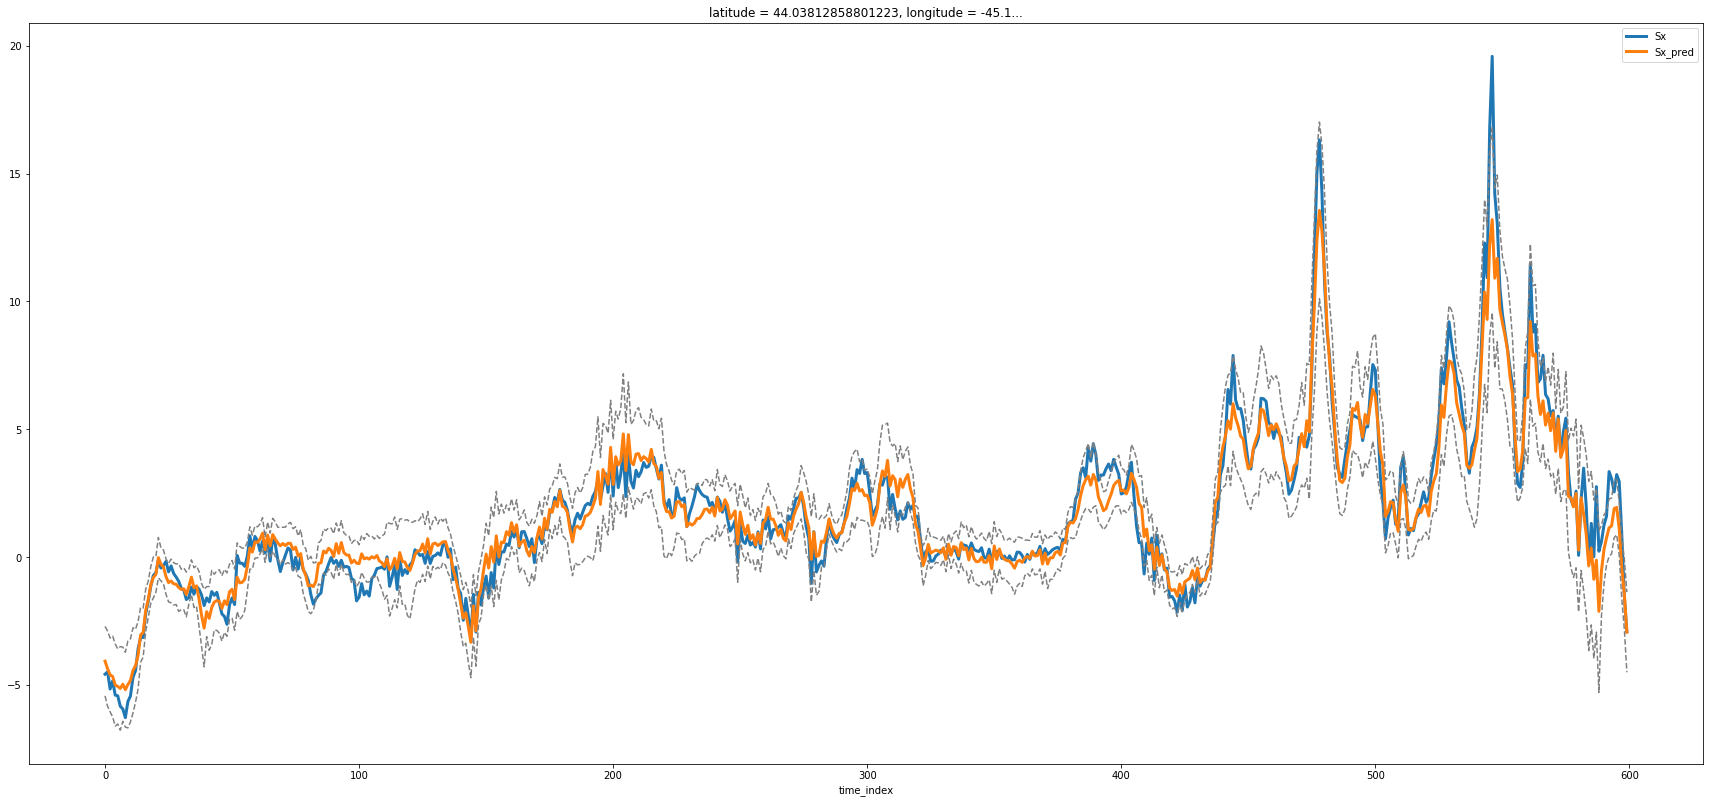

In [16]:
fig = plt.figure(figsize=(30, 30))
long = -45
lat = 44
plt.subplot(2, 1, 1)
time = slice(0, 600)
model_output['S_x'].isel(time_index=time).sel(longitude=long, latitude=lat, method='nearest').plot(linewidth=3)
model_output['S_xpred'].isel(time_index=time).sel(longitude=long, latitude=lat, method='nearest').plot(linewidth=3)
uB = model_output['S_xpred'] + 1.96 * model_output['S_xscale']
lB = model_output['S_xpred'] - 1.96 * model_output['S_xscale']
uB.isel(time_index=time).sel(longitude=long, latitude=lat, method='nearest').plot(linestyle='--',color='gray')
lB.isel(time_index=time).sel(longitude=long, latitude=lat, method='nearest').plot(linestyle='--',color='gray')
plt.legend(('Sx', 'Sx_pred'))

In [17]:
correlations = (model_output['S_y'] * model_output['S_ypred']).mean(dim='time_index') / np.sqrt((model_output['S_y']**2).mean(dim='time_index') * (model_output['S_ypred']**2).mean(dim='time_index'))

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


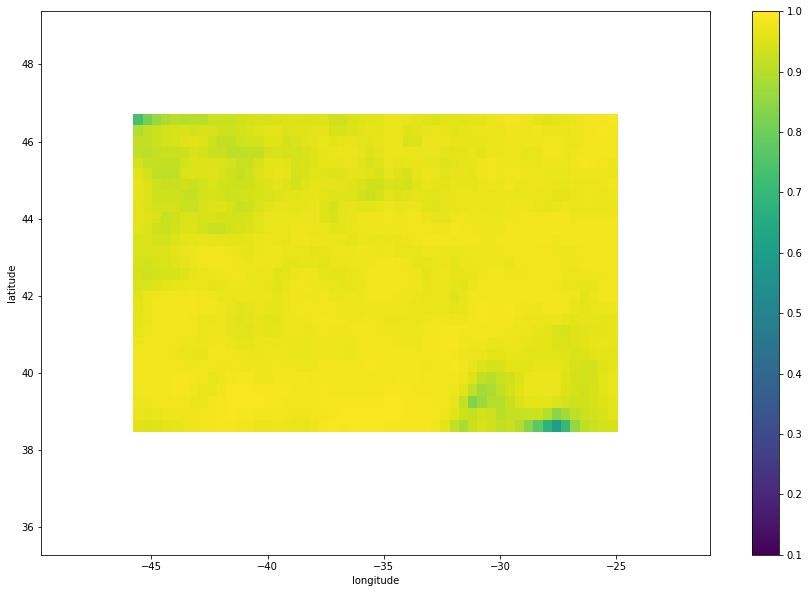

In [18]:
correlations.plot(vmin=0.1, vmax=1)